In [4]:
from torchvision import transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader , Subset
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import os

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

print("Path to dataset files:", path)

100%|██████████| 1.65G/1.65G [00:14<00:00, 125MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zaraks/pascal-voc-2007/versions/1


In [7]:
import os
from torchvision import transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

# Construct the correct root paths for the training/validation and test sets
train_val_path = os.path.join(path, "VOCtrainval_06-Nov-2007")
test_path = os.path.join(path, "VOCtest_06-Nov-2007")

print("Train/Val path:", train_val_path)
print("Test path:", test_path)

# Defining the transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load Pascal VOC dataset for training/validation and testing

train_dataset = VOCDetection(root=train_val_path, year='2007', image_set='trainval', download=False, transform=transform)
test_dataset = VOCDetection(root=test_path, year='2007', image_set='test', download=False, transform=transform)

# Custom collate function to handle variable number of bounding boxes
def custom_collate_fn(data):
    return tuple(zip(*data))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

print("Dataset and DataLoaders created successfully!")

Train/Val path: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
Test path: /kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007
Dataset and DataLoaders created successfully!


In [8]:
len(train_dataset), len(test_dataset)

(5011, 4952)

In [9]:
# Mappings of label names (found in dataset annotation) to integer IDs (or classes) which we will feed to the model
voc_classes = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19,
}

#  Reverse of label to class id mapping. needed because the model predictions will be ids and we need to change it to label to visualize it.
reverse_voc_classes = {v: k for k, v in voc_classes.items()}

## The Pretrained  Model

In [10]:
import torchvision

# Load pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# Change number of output classes to match Pascal VOC dataset
num_classes = 20  # Pascal VOC has 20 object classes
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Input features for predictor

# Replace final layer with new predictor
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


# Freeze the backbone and just finetune the head (You can finetune the whole model, but it'd take time and resources)
model.requires_grad_(False)
model.roi_heads.box_predictor = model.roi_heads.box_predictor.requires_grad_(True)


# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:01<00:00, 62.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## Training Loop

In [11]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for images, targets in tqdm(dataloader):
        images = list(img.to(device) for img in images)

        # Convert targets
        for target in targets:
            boxes = []
            labels = []
            for obj in target['annotation']['object']:
                label = obj['name']
                box = obj['bndbox']
                xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
                boxes.append(torch.Tensor([xmin, ymin, xmax, ymax]).to(device))
                labels.append(voc_classes[label])

            target['boxes'] = torch.stack(boxes)
            target['labels'] = torch.Tensor(labels).type(torch.int64).to(device)

        # Compute losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Sum all losses

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [13]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 27.8 MB/s eta 0:00:00


## Validation Loop

In [14]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Initialize metric
metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def validate(model, dataloader, device):
    """Evaluates the model using mAP@0.5:0.95."""
    model.eval()
    metric.reset()

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(device) for img in images]
            preds = model(images)

            # Convert predictions to correct format
            processed_preds = []
            for pred in preds:
                processed_preds.append({
                    "boxes": pred["boxes"].cpu(),
                    "scores": pred["scores"].cpu(),
                    "labels": pred["labels"].cpu()
                })

            # Convert ground truth targets
            processed_targets = []
            for target in targets:
                gt_boxes = []
                gt_labels = []
                for obj in target['annotation']['object']:
                    label = obj['name']
                    box = obj['bndbox']
                    xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
                    gt_boxes.append([xmin, ymin, xmax, ymax])
                    gt_labels.append(voc_classes[label])

                processed_targets.append({
                    "boxes": torch.tensor(gt_boxes).cpu(),
                    "labels": torch.tensor(gt_labels).cpu()
                })

            # Update metric
            metric.update(processed_preds, processed_targets)

    return metric.compute()  # Compute final mAP scores

## Running Time

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
num_epochs = 10  # Set number of epochs

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    mAP_results = validate(model, test_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")
    print(f"mAP@0.5:0.95 for Test: {mAP_results['map']:.4f}")

100%|██████████| 4952/4952 [02:32<00:00, 32.49it/s]


Epoch 1/10, Loss: 0.7659
mAP@0.5:0.95 for Test: 0.4617


100%|██████████| 4952/4952 [02:32<00:00, 32.44it/s]


Epoch 2/10, Loss: 0.5426
mAP@0.5:0.95 for Test: 0.4739


100%|██████████| 4952/4952 [02:27<00:00, 33.55it/s]


Epoch 3/10, Loss: 0.5236
mAP@0.5:0.95 for Test: 0.4810


100%|██████████| 4952/4952 [02:27<00:00, 33.57it/s]


Epoch 4/10, Loss: 0.5148
mAP@0.5:0.95 for Test: 0.4809


100%|██████████| 4952/4952 [02:27<00:00, 33.54it/s]


Epoch 5/10, Loss: 0.5071
mAP@0.5:0.95 for Test: 0.4808


100%|██████████| 4952/4952 [02:27<00:00, 33.62it/s]


Epoch 6/10, Loss: 0.5013
mAP@0.5:0.95 for Test: 0.4788


100%|██████████| 4952/4952 [02:27<00:00, 33.59it/s]


Epoch 7/10, Loss: 0.4977
mAP@0.5:0.95 for Test: 0.4784


100%|██████████| 4952/4952 [02:27<00:00, 33.54it/s]


Epoch 8/10, Loss: 0.4945
mAP@0.5:0.95 for Test: 0.4822


100%|██████████| 4952/4952 [02:27<00:00, 33.48it/s]


Epoch 9/10, Loss: 0.4911
mAP@0.5:0.95 for Test: 0.4771


100%|██████████| 4952/4952 [02:27<00:00, 33.59it/s]


Epoch 10/10, Loss: 0.4885
mAP@0.5:0.95 for Test: 0.4784


## Visualizing Predictions vs Ground Truth


In [18]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
# Helper function to overlay Ground Truth & Predicted Boxes
def visualize_gt_pred(img, gt_boxes, gt_annotations, pred_boxes, pred_annotations, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Plot Ground Truth in RED
    for bbox, annotation in zip(gt_boxes, gt_annotations):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min - 5, annotation, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    # Plot Predictions in GREEN
    for bbox, annotation in zip(pred_boxes, pred_annotations):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min - 5, annotation, color='g', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.title(title)
    plt.show()

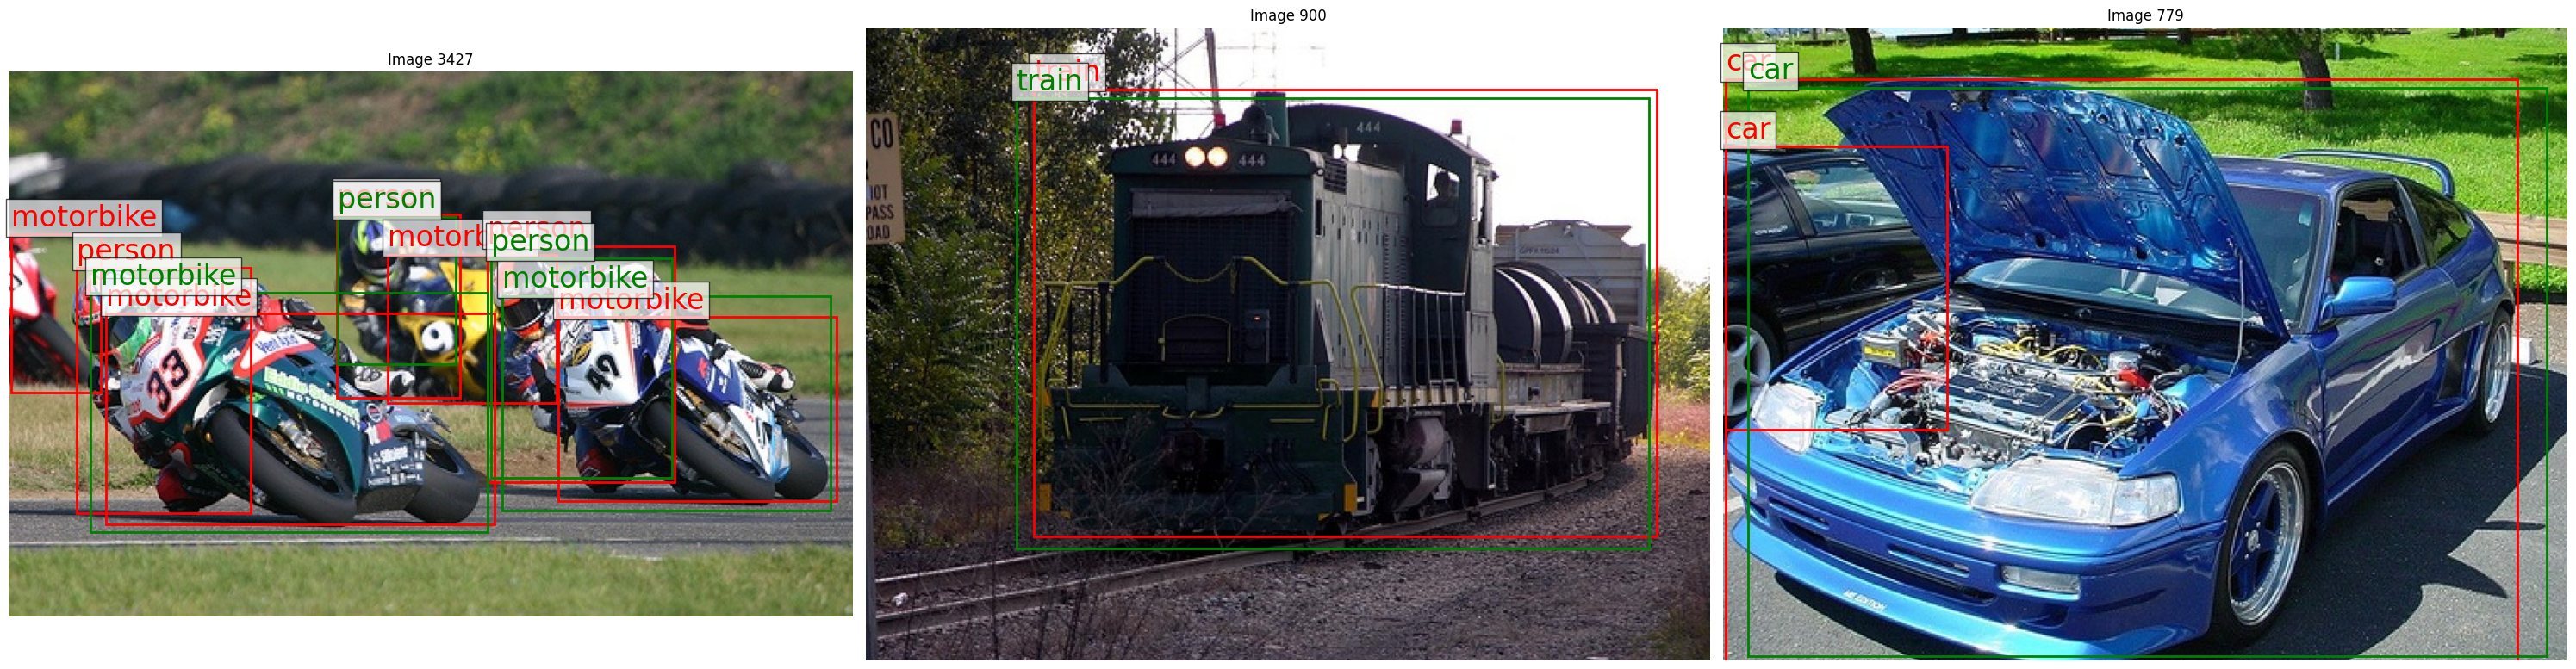

In [22]:
# Select 3 random test images
test_indices = [3427, 900, 779]

# Set model to evaluation mode
model.eval()

# Create figure with 5×2 subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 60))
axes = axes.ravel()  # Flatten axes for easy iteration

for i, idx in enumerate(test_indices):
    test_img, test_target = test_dataset[idx]

    # Extract Ground Truth Boxes & Labels
    gt_boxes = []
    gt_annotations = []
    for obj in test_target['annotation']['object']:
        box = obj['bndbox']
        xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
        gt_boxes.append([xmin, ymin, xmax, ymax])
        gt_annotations.append(obj['name'])

    # Run Model on Test Image
    with torch.no_grad():
        pred = model([test_img.to(device)])

    pred = pred[0]

    # Extract Predictions
    pred_boxes = pred['boxes'].cpu()
    pred_annotations = pred['labels'].cpu()
    pred_scores = pred['scores'].cpu()

    # Apply Confidence Threshold (Only keep predictions with score ≥ 0.8)
    valid_mask = pred_scores >= 0.8
    pred_annotations = pred_annotations[valid_mask]
    pred_boxes = pred_boxes[valid_mask]

    # Convert Predicted Labels from Numeric to Class Names
    pred_annotations = [reverse_voc_classes[val.item()] for val in pred_annotations]

    # Overlay GT & Predictions on Image
    img = F.to_pil_image(test_img)
    ax = axes[i]
    ax.imshow(img)

    # Plot Ground Truth in RED
    for bbox, annotation in zip(gt_boxes, gt_annotations):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, annotation, color='r', fontsize=24, bbox=dict(facecolor='white', alpha=0.7))

    # Plot Predictions in GREEN
    for bbox, annotation in zip(pred_boxes, pred_annotations):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, annotation, color='g', fontsize=24, bbox=dict(facecolor='white', alpha=0.7))

    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.show()

# **(*>﹏<)(>﹏<)(>﹏<*)**
